In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define directories and parameters
data_dir = '/content/drive/MyDrive/zz/grayscale/'
# data_dir = '/home/beki/Desktop/research/Research/capsul/datasett/train'
classes = ['happy', 'sad', 'angry','neutral','surprise']
img_size = (128,128)
batch_size = 32

# Function to read and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = cv2.medianBlur(img, 5)  # Apply median filter to reduce noise
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)  # Resize using cubic interpolation
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
            labels.append(label)
    return images, labels





In [ ]:
# Load images and labels
all_images = []
all_labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    images, labels = load_images_from_folder(cls_folder, idx)
    all_images.extend(images)
    all_labels.extend(labels)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Normalize images and ensure they have the correct shape
all_images = all_images.astype('float32') / 255.0

# Split dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=20, stratify=all_labels)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=20, stratify=y_temp)

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    'balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


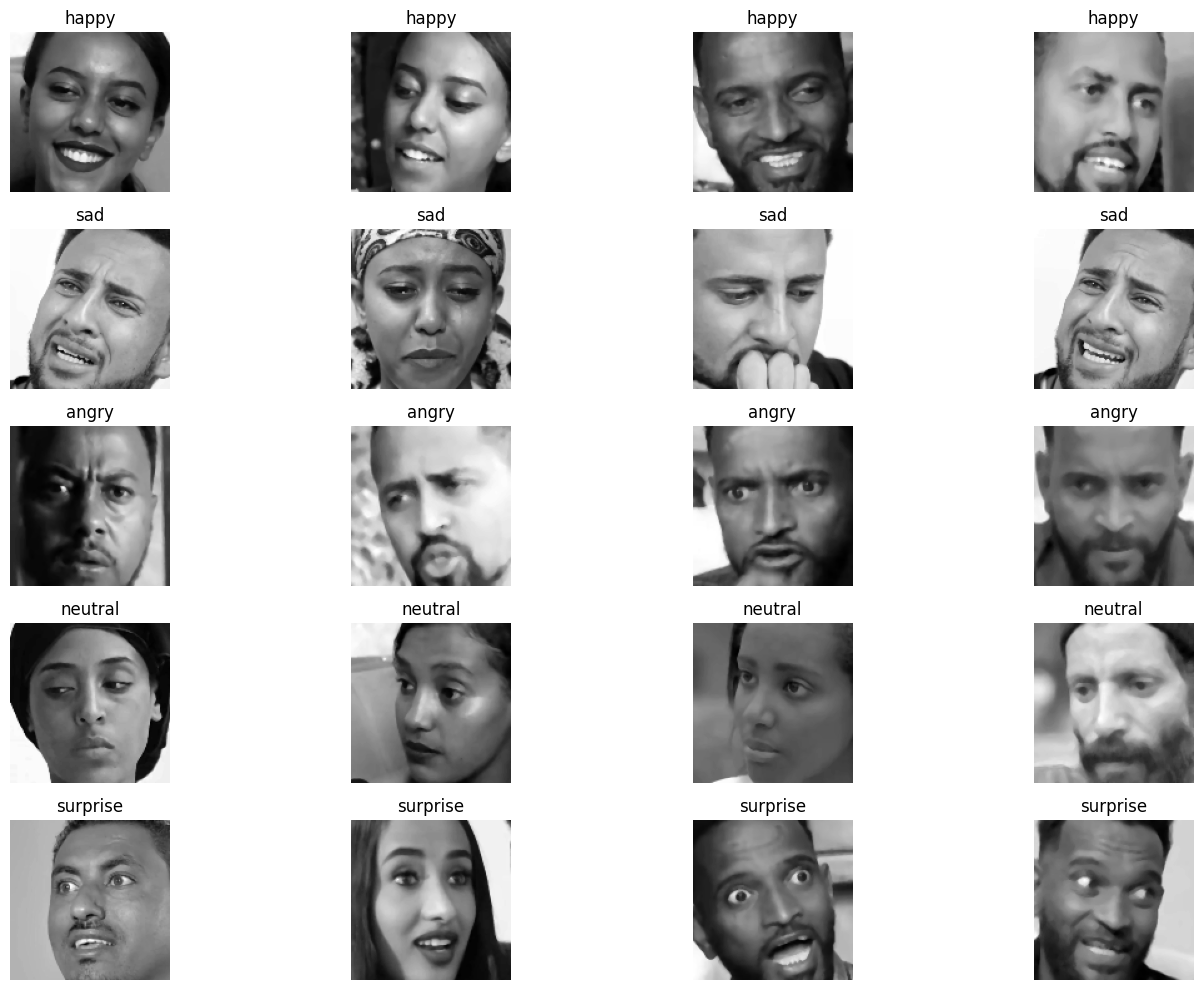

In [ ]:
# Display some sample images from each class
def display_sample_images(images, labels, classes, num_samples=4):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        indices = np.where(labels == i)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx].squeeze(), cmap='gray')
            plt.title(f'{cls}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(all_images, all_labels, classes)

In [ ]:
# Define a more complex CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #Dropout(0.1),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,781,445 (33.50 MB)

 Trainable params: 8,780,485 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
callbacks = [early_stopping, lr_scheduler]


In [ ]:
# Train the model using separate validation data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=120,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 313ms/step - accuracy: 0.3373 - loss: 2.5055 - val_accuracy: 0.2796 - val_loss: 2.3533 - learning_rate: 1.0000e-04
Epoch 2/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4402 - loss: 1.4330 - val_accuracy: 0.3733 - val_loss: 2.7190 - learning_rate: 1.0000e-04
Epoch 3/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4822 - loss: 1.2916 - val_accuracy: 0.3733 - val_loss: 2.4818 - learning_rate: 1.0000e-04
Epoch 4/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5285 - loss: 1.2229 - val_accuracy: 0.4187 - val_loss: 1.7011 - learning_rate: 1.0000e-04
Epoch 5/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5636 - loss: 1.1438 - val_accuracy: 0.6364 - val_loss: 0.9616 - learning_rate: 1.0000e-04
Epoch 6/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.5689 - loss: 1.1369 - val_accuracy: 0.6942 - val_loss: 0.8544 - learning_rate: 1.0000e-04
Epoch 7/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accu

In [ ]:
model.save('modeltop22.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


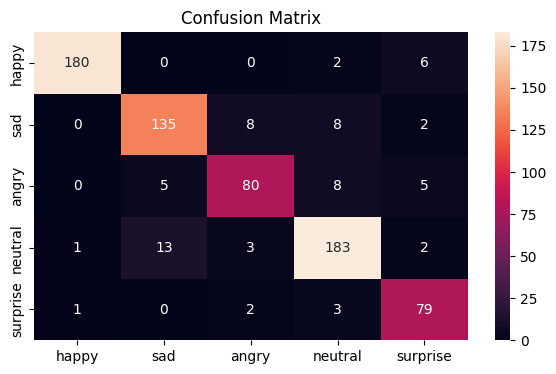

Classification Report:
              precision    recall  f1-score   support

       happy       0.99      0.96      0.97       188
         sad       0.88      0.88      0.88       153
       angry       0.86      0.82      0.84        98
     neutral       0.90      0.91      0.90       202
    surprise       0.84      0.93      0.88        85

    accuracy                           0.90       726
   macro avg       0.89      0.90      0.90       726
weighted avg       0.91      0.90      0.91       726



In [ ]:

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

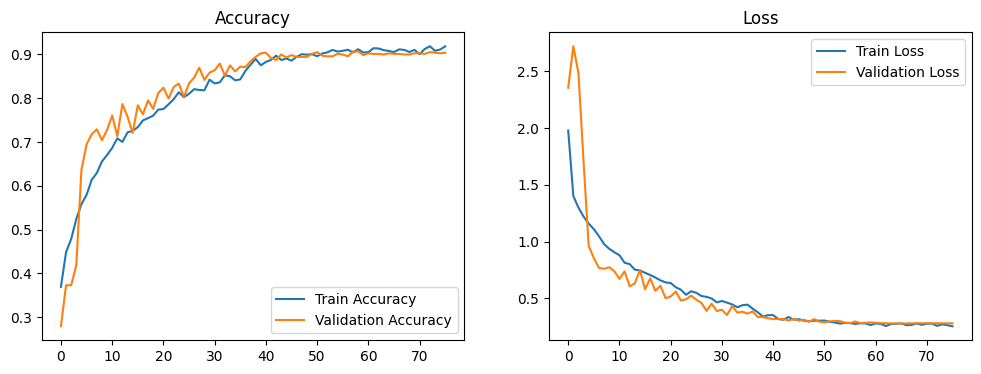

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
# Function to predict emotion for new image
def predict_emotion(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.resize(img, img_size)  # Resize image
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        pred = model.predict(img)
        return classes[np.argmax(pred)]
    else:
        return "Image not found"

# Example of predicting a new image
new_image_path = '/content/drive/MyDrive/bekii/test/happy/im250.png'
print("Predicted Emotion:", predict_emotion(new_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicted Emotion: happy
